In [2]:
import os
os.chdir('/home/rm/ssd2/langcao/workspace/tablemaster')
!pwd

/home/rm/ssd2/langcao/workspace/tablemaster


In [11]:
import matplotlib.font_manager as fm

# check system fonts
available_fonts = [f.name for f in fm.fontManager.ttflist]
print(available_fonts)

# install font
# sudo apt install ttf-mscorefonts-installer
# mkdir ~/.fonts
# fc-list | grep -i calibri

['DejaVu Sans', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'STIXSizeOneSym', 'STIXSizeTwoSym', 'DejaVu Serif', 'STIXSizeFourSym', 'STIXSizeFiveSym', 'DejaVu Serif Display', 'STIXGeneral', 'STIXGeneral', 'STIXNonUnicode', 'DejaVu Sans Display', 'cmmi10', 'cmr10', 'STIXNonUnicode', 'cmex10', 'cmss10', 'STIXSizeThreeSym', 'STIXSizeOneSym', 'STIXSizeFourSym', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXNonUnicode', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Sans Mono', 'STIXNonUnicode', 'cmb10', 'STIXSizeThreeSym', 'STIXGeneral', 'STIXGeneral', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans', 'cmsy10', 'cmtt10', 'DejaVu Serif', 'Liberation Sans', 'DejaVu Serif', 'Trebuchet MS', 'Verdana', 'Verdana', 'Courier New', 'Times New Roman', 'DejaVu Serif', 'DejaVu Sans', 'Comic Sans MS', 'Liberation Sans Narrow', 'Georgia', 'DejaVu Sans', 'Trebuchet MS', 'Liberation Sans', 'Trebuchet MS', 'Georgia', 'DejaVu Sans', 'DejaVu Math TeX Gyre', 'Liberation Serif', 'Liberation Sans', 'DejaVu Sans Mon

In [12]:
import os
import sys
import json
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import tiktoken
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('./')
from evaluate.evaluator import eval_qa, eval_fact
from table_utils import format_table

In [13]:
prompt_method = 'direct'
# prompt_method = 'cot'

output_paths = {
    'gpt4m': f'outputs/baselines/wikitq/gpt4m/{prompt_method}',
    'gpt35': f'outputs/baselines/wikitq/gpt35/{prompt_method}',
    'gpt4o': f'outputs/baselines/wikitq/gpt4o/{prompt_method}'
}

row_sizes = []
col_sizes = []
area_sizes = []
token_sizes = []
results = {
    'gpt4m': [],
    'gpt35': [],
    'gpt4o': []
}

encoding = tiktoken.get_encoding("cl100k_base")


for model, output_path in output_paths.items():
    files = glob.glob(f'{output_path}/*.json')
    files = sorted(files, key=lambda x: int(x.split('/')[-1].split('.')[0]))

    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)

        result = 1 if eval_qa(data['predicted_answer'], data['answer']) else 0
        results[model].append(result)

        if model == 'gpt4m':
            row_size = len(data['table'])
            col_size = len(data['table'][0])
            area_size = row_size * col_size

            table_md = format_table(data['table'], with_address=False)
            token_size = len(encoding.encode(table_md))

            row_sizes.append(row_size)
            col_sizes.append(col_size)
            area_sizes.append(area_size)
            token_sizes.append(token_size)

In [6]:
# check statistic
statistic_df = pd.DataFrame({'row_size': row_sizes, 'col_size': col_sizes, 'area_size': area_sizes, 'token_size': token_sizes})
statistic_df.describe()
# row: 6-519
# col: 3-22
# area: 24-2590
# token: 111-10656

,row_size,col_size,area_size,token_size
count,4344.000000,4344.000000,4344.000000,4344.000000
mean,26.404006,6.294659,164.438766,784.837937
std,43.802316,1.843949,253.055167,1169.513805
min,6.000000,3.000000,24.000000,111.000000
25%,11.000000,5.000000,65.000000,272.000000
50%,16.000000,6.000000,96.000000,447.000000
75%,26.000000,7.000000,168.000000,783.000000
max,518.000000,21.000000,2590.000000,10655.000000


In [7]:
plt.rcParams['font.family'] = 'Calibri'

models = ['gpt4o', 'gpt4m', 'gpt35']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

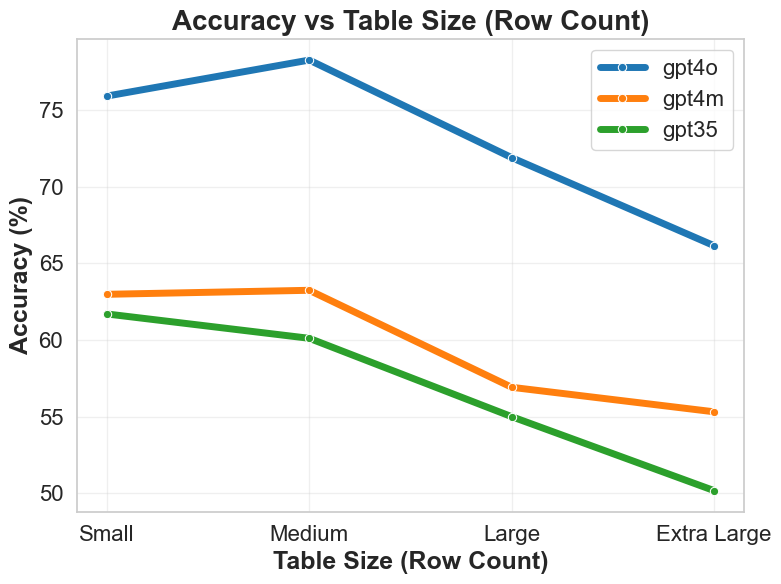

In [10]:
## Row Count Analysis
fig, ax = plt.subplots(figsize=(8, 6))

# Common parameters
bin_edges = [6, 11, 16, 26, 519]
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]

# Iterate over models to process and plot
summaries = {}
for model, color in zip(models, colors):
    tmp_results = results[model]
    size_metric = row_sizes
    bin_indices = np.digitize(size_metric, bins=bin_edges, right=False) - 1

    # Create bin data and dataframe
    bin_data = [{"Size Range": bin_labels[bin_indices[i]], "Result": result} for i, result in enumerate(tmp_results)]
    bin_df = pd.DataFrame(bin_data)
    
    # Calculate summary statistics
    summary = bin_df.groupby("Size Range").agg(Accuracy=("Result", "mean")).reset_index()
    summary['Size Range'] = pd.Categorical(summary['Size Range'], categories=bin_labels, ordered=True)
    summary = summary.sort_values('Size Range')
    summary["Accuracy"] *= 100
    # Plot the data
    sns.lineplot(data=summary, x="Size Range", y="Accuracy", marker="o", color=color, label=model, linewidth=5)

# Customize the plot
sns.set_theme(style="whitegrid")
plt.title("Accuracy vs Table Size (Row Count)", fontsize=20, fontweight='bold')
plt.xlabel("Table Size (Row Count)", fontsize=18, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=18, fontweight='bold')
plt.xticks(plt.gca().get_xticks(), ['Small', 'Medium', 'Large', 'Extra Large'], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=16)
plt.tight_layout()

# Save and show the plot
plt.savefig('figures/challenges/size_analysis_row.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

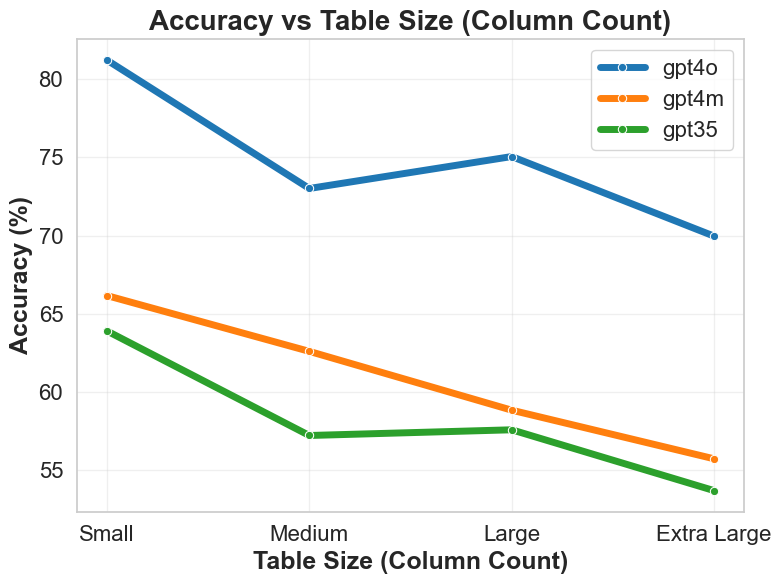

In [8]:
## Column Count Analysis
fig, ax = plt.subplots(figsize=(8, 6))

# Common parameters
bin_edges = [3, 5, 6, 7, 22]
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]

# Iterate over models to process and plot
summaries = {}
for model, color in zip(models, colors):
    tmp_results = results[model]
    size_metric = col_sizes
    bin_indices = np.digitize(size_metric, bins=bin_edges, right=False) - 1

    # Create bin data and dataframe
    bin_data = [{"Size Range": bin_labels[bin_indices[i]], "Result": result} for i, result in enumerate(tmp_results)]
    bin_df = pd.DataFrame(bin_data)
    
    # Calculate summary statistics
    summary = bin_df.groupby("Size Range").agg(Accuracy=("Result", "mean")).reset_index()
    summary['Size Range'] = pd.Categorical(summary['Size Range'], categories=bin_labels, ordered=True)
    summary = summary.sort_values('Size Range')
    summary["Accuracy"] *= 100

    # Plot the data
    sns.lineplot(data=summary, x="Size Range", y="Accuracy", marker="o", color=color, label=model, linewidth=5)

# Customize the plot
sns.set_theme(style="whitegrid")
plt.title("Accuracy vs Table Size (Column Count)", fontsize=20, fontweight='bold')
plt.xlabel("Table Size (Column Count)", fontsize=18, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=18, fontweight='bold')
plt.xticks(plt.gca().get_xticks(), ['Small', 'Medium', 'Large', 'Extra Large'], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=16)
plt.tight_layout()

# Save and show the plot
plt.savefig('figures/challenges/size_analysis_column.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

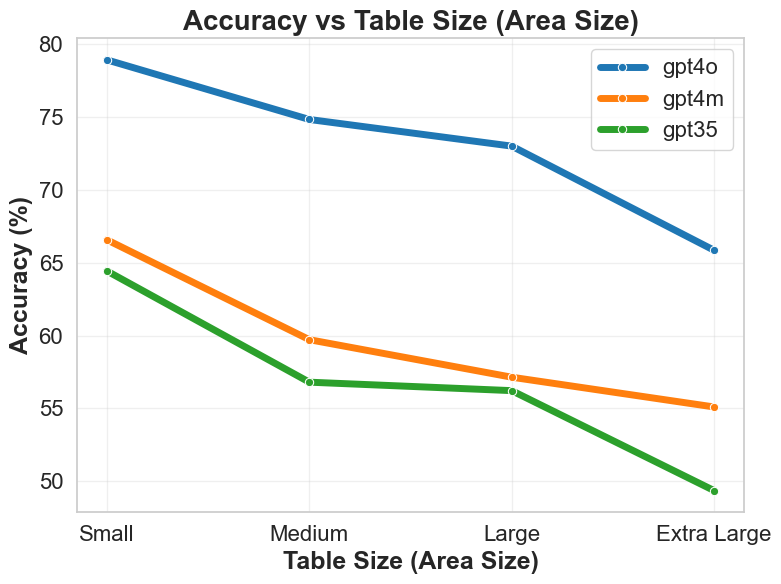

In [9]:
## Area Size Analysis
fig, ax = plt.subplots(figsize=(8, 6))

# Common parameters
bin_edges = [24, 65, 96, 168, 2591]
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]

# Iterate over models to process and plot
summaries = {}
for model, color in zip(models, colors):
    tmp_results = results[model]
    size_metric = area_sizes
    bin_indices = np.digitize(size_metric, bins=bin_edges, right=False) - 1

    # Create bin data and dataframe
    bin_data = [{"Size Range": bin_labels[bin_indices[i]], "Result": result} for i, result in enumerate(tmp_results)]
    bin_df = pd.DataFrame(bin_data)
    
    # Calculate summary statistics
    summary = bin_df.groupby("Size Range").agg(Accuracy=("Result", "mean")).reset_index()
    summary['Size Range'] = pd.Categorical(summary['Size Range'], categories=bin_labels, ordered=True)
    summary = summary.sort_values('Size Range')
    summary["Accuracy"] *= 100
    # Plot the data
    sns.lineplot(data=summary, x="Size Range", y="Accuracy", marker="o", color=color, label=model, linewidth=5)

# Customize the plot
sns.set_theme(style="whitegrid")
plt.title("Accuracy vs Table Size (Area Size)", fontsize=20, fontweight='bold')
plt.xlabel("Table Size (Area Size)", fontsize=18, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=18, fontweight='bold')
plt.xticks(plt.gca().get_xticks(), ['Small', 'Medium', 'Large', 'Extra Large'], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=16)
plt.tight_layout()

# Save and show the plot
plt.savefig('figures/challenges/size_analysis_area.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

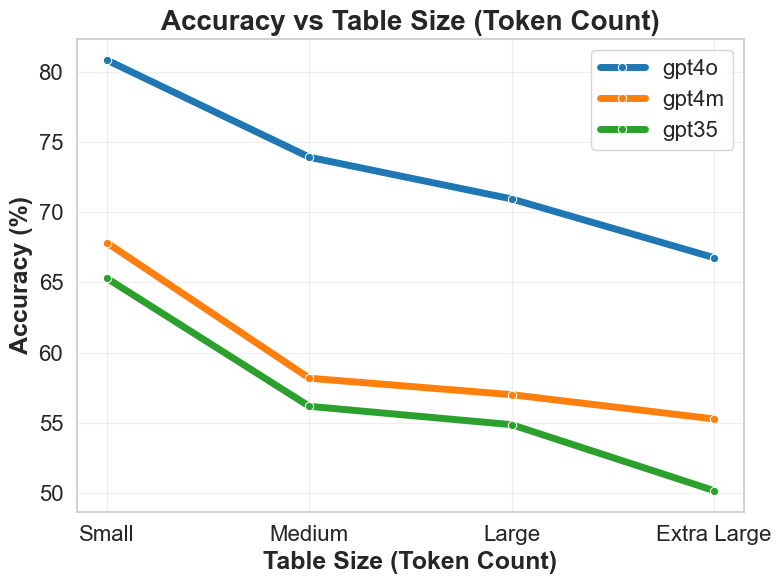

In [10]:
## Token Size Analysis
fig, ax = plt.subplots(figsize=(8, 6))

# Common parameters
bin_edges = [111, 272, 447, 783, 10656]
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges) - 1)]

# Iterate over models to process and plot
summaries = {}
for model, color in zip(models, colors):
    tmp_results = results[model]
    size_metric = token_sizes
    bin_indices = np.digitize(size_metric, bins=bin_edges, right=False) - 1

    # Create bin data and dataframe
    bin_data = [{"Size Range": bin_labels[bin_indices[i]], "Result": result} for i, result in enumerate(tmp_results)]
    bin_df = pd.DataFrame(bin_data)
    
    # Calculate summary statistics
    summary = bin_df.groupby("Size Range").agg(Accuracy=("Result", "mean")).reset_index()
    summary['Size Range'] = pd.Categorical(summary['Size Range'], categories=bin_labels, ordered=True)
    summary = summary.sort_values('Size Range')
    summary["Accuracy"] *= 100

    # Plot the data
    sns.lineplot(data=summary, x="Size Range", y="Accuracy", marker="o", color=color, label=model, linewidth=5)

# Customize the plot
sns.set_theme(style="whitegrid")
plt.title("Accuracy vs Table Size (Token Count)", fontsize=20, fontweight='bold')
plt.xlabel("Table Size (Token Count)", fontsize=18, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=18, fontweight='bold')
plt.xticks(plt.gca().get_xticks(), ['Small', 'Medium', 'Large', 'Extra Large'], fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=16)
plt.tight_layout()

# Save and show the plot
plt.savefig('figures/challenges/size_analysis_token.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
